<a href="https://colab.research.google.com/github/larissavaladao/py6s_harmonize_sample/blob/main/6.%20parameters_by_period/area_spm_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

Landsat 7 - PY6S

In [4]:
landsat7 = ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD7/Landsat7")\
            .select([ 'B1', 'B2', 'B3', 'B4', 'B5', 'B7'])
print(ee.Date(landsat7.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat7.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2000-02-18T13:40:29
2017-09-28T13:50:48


In [5]:
print(landsat7.aggregate_histogram('WRS_PATH').getInfo())
print(landsat7.aggregate_histogram('WRS_ROW').getInfo())

{'227.0': 526, '228.0': 162}
{'61.0': 354, '62.0': 334}


In [6]:
print(landsat7.filter(ee.Filter.eq('WRS_PATH',227.0)).aggregate_histogram('WRS_ROW').getInfo())
print(landsat7.filter(ee.Filter.eq('WRS_PATH',228.0)).aggregate_histogram('WRS_ROW').getInfo())

{'61.0': 262, '62.0': 264}
{'61.0': 92, '62.0': 70}


Landsat 8 PY6S

In [7]:
landsat8 = (ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD8/Landsat8")
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7']))
print(ee.Date(landsat8.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat8.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2013-05-20T13:49:50
2017-09-20T13:48:22


In [8]:
print(landsat8.aggregate_histogram('WRS_PATH').getInfo())
print(landsat8.aggregate_histogram('WRS_ROW').getInfo())

{'227.0': 155, '228.0': 151}
{'61.0': 154, '62.0': 152}


In [9]:
print(landsat7.filter(ee.Filter.eq('WRS_PATH',227.0)).aggregate_histogram('WRS_ROW').getInfo())
print(landsat7.filter(ee.Filter.eq('WRS_PATH',228.0)).aggregate_histogram('WRS_ROW').getInfo())

{'61.0': 262, '62.0': 264}
{'61.0': 92, '62.0': 70}


# Transform into remote sensing reflectance and sunglint correction

In [10]:
def deglint (img):
  '''#dividir imagem corrigida por pi
  Rrs_sat_ac = Rsat_ac / pi
  fazer deglint
  Rrs_sat_ac_deglint(VNIR) = Rrs_sat_ac (VNIR) − Rrs_sat_ac (SWIR)
  correção no artigo INPE CURUAI'''
  Rrs = img.divide(math.pi)
  deglint = Rrs.select(['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2'])\
    .subtract(Rrs.select('swir1'))

  return (deglint
          .copyProperties(img,['system:time_start','CLOUD_COVER',"system:index"]))

## Padronize band names

In [11]:
name_bands = ['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2']

Landsat 7

In [12]:
#renomear bandas

ld7 = landsat7.map(lambda img: img.rename(name_bands))
ld7.first()

Landsat 8

In [13]:
ld8 = landsat8.map(lambda img: img.rename(name_bands))
ld8

In [14]:
merge_col = ld8.merge(ld7).sort('system:time_start').map(deglint)
merge_col.limit(5)

# Fazer mosaico por mes

In [15]:
years = ee.List.sequence(2000,2017);
months = ee.List.sequence(1,12,3);
months

In [16]:
monthly_mosaics =  ee.ImageCollection.fromImages(
    years.map(lambda y: months.map(lambda m: merge_col.filter(ee.Filter.calendarRange(y, y, 'year'))
    .filter(ee.Filter.calendarRange(m, ee.Number(m).add(2), 'month')).median()
    .set('year', y).set('month_init', m).set('month_end', ee.Number(m).add(2)).set('system:time_start', ee.Date.fromYMD(y, m, 1)).set('timestamp', ee.Date.fromYMD(y, m, 1).format('yyyy-MM-dd'))
    )).flatten());
display(monthly_mosaics )

In [17]:
monthly_mosaic = monthly_mosaics.map(lambda img: img.set('band_count',img.bandNames().length())).filter(ee.Filter.gt('band_count',0))
monthly_mosaic

# Export as Asset: Image Collection

# Mask land

In [18]:
def hsvComposite (image):
    composite = image.select(['blue_mean','green_mean','red_mean']).rgbToHsv()#.clip(limits);
    hue = composite.select("hue");
    max_mask = hue.lte(0.9)
    min_mask = hue.gte(0.3)
    return image.updateMask(max_mask).updateMask(min_mask).select(['blue_mean','green_mean','red_mean','nir_mean']);

#calculate area

In [19]:
def area_calc(img):
  '''receives an image of curuai and returns water surface area in km2 within the floodplain limits
  as a property of the input image'''

  # Get a pixel area image.
  pixel_area = ee.Image.pixelArea()

  floodplain = ee.FeatureCollection('projects/ee-curuai/assets/vectors/varzea_alagavel')
  image = hsvComposite(img)
  img_mask = image.gt(0)

  areaImage = img_mask.multiply(pixel_area)

  area = areaImage.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })
  return image.set('area_km2',ee.Number(area.get('red_mean')).divide(1e6))


In [20]:
monthly_area = monthly_mosaic.map(hsvComposite).map(area_calc)

monthly_area

In [27]:
dfArea = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(monthly_area.map(lambda img: ee.Feature(None,img.toDictionary()))),
    'fileFormat': 'PANDAS_DATAFRAME'
})
dfArea

geo     area_km2  band_count  month_end  month_init   timestamp  year
0   None   983.778969           6          3           1  2000-01-01  2000
1   None  1111.052941           6          6           4  2000-04-01  2000
2   None  1335.361963           6          9           7  2000-07-01  2000
3   None  1063.043198           6         12          10  2000-10-01  2000
4   None     7.913670           6          3           1  2001-01-01  2001
..   ...          ...         ...        ...         ...         ...   ...
65  None  1372.726041           6          9           7  2016-07-01  2016
66  None   768.152708           6         12          10  2016-10-01  2016
67  None  1106.393697           6          3           1  2017-01-01  2017
68  None  1486.713402           6          6           4  2017-04-01  2017
69  None  1465.984238           6          9           7  2017-07-01  2017

[70 rows x 7 columns]

In [28]:
def return_period(month):
  if month == 1:
    return 'R'
  elif month == 4:
    return 'HW'
  elif month == 7:
    return 'F'
  elif month == 10:
    return 'LW'
  else:
    return 'U'

In [29]:
dfArea = dfArea[['area_km2',	'month_end',	'month_init',	'timestamp',	'year']].copy()
dfArea['WATER_PERIOD'] = dfArea.apply(lambda row: return_period(row['month_init']),axis = 1)
dfArea

area_km2  month_end  month_init   timestamp  year WATER_PERIOD
0    983.778969          3           1  2000-01-01  2000            R
1   1111.052941          6           4  2000-04-01  2000           HW
2   1335.361963          9           7  2000-07-01  2000            F
3   1063.043198         12          10  2000-10-01  2000           LW
4      7.913670          3           1  2001-01-01  2001            R
..          ...        ...         ...         ...   ...          ...
65  1372.726041          9           7  2016-07-01  2016            F
66   768.152708         12          10  2016-10-01  2016           LW
67  1106.393697          3           1  2017-01-01  2017            R
68  1486.713402          6           4  2017-04-01  2017           HW
69  1465.984238          9           7  2017-07-01  2017            F

[70 rows x 6 columns]

In [30]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'area_km2',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

<Axes: xlabel='timestamp', ylabel='area_km2'>

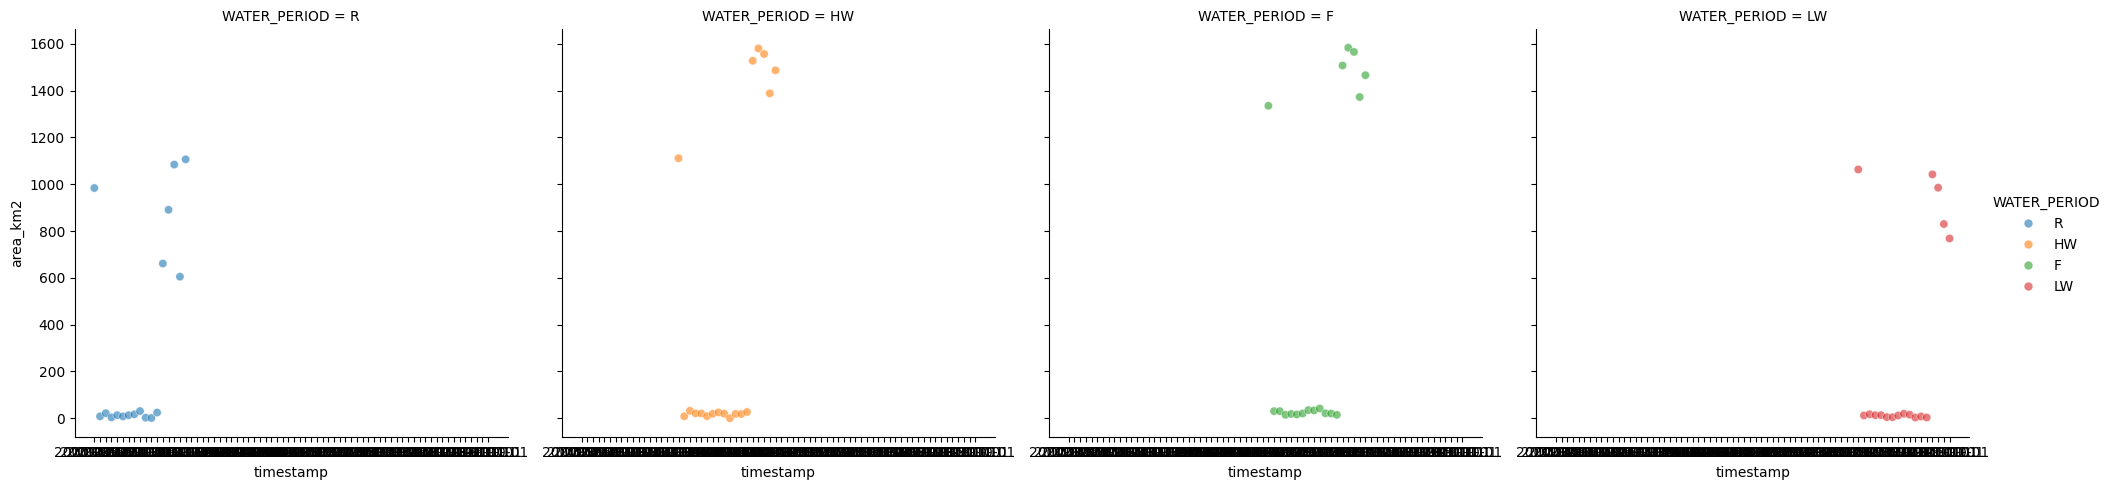

In [40]:

sns.relplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

In [41]:
col = merge_col.filterDate('2015-10-01','2016-01-01')
col.size()

In [42]:
Map = geemap.Map(basemap='HYBRID')
roi_points = ee.FeatureCollection('projects/ee-curuai/assets/curuai_points')
Map.centerObject(roi_points,10)

year = ee.Filter.eq('year',2000)
month = ee.Filter.eq('month_init',1)

Map.addLayer(monthly_area.filter(year).filter(month), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'monthly composite')
# Map.addLayer(col, {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, ' collection')

Map.addLayer(ee.FeatureCollection('projects/ee-curuai/assets/vectors/varzea_alagavel'),{'color':'red'},'limite varzea alagavel')

Map.addLayer(roi_points, {'color':'darkred'}, 'Data polygon');
Map

Map(center=[-2.184599717160098, -55.49304633852027], controls=(WidgetControl(options=['position', 'transparent…

# Import Model and Classify Images

In [43]:
classifier = ee.Classifier.load('projects/ee-curuai/assets/RF_regressor')
classifier

In [44]:
predictors = ['blue_mean', 'green_mean','red_mean', 'nir_mean']
spm_classified = monthly_area.select(predictors).map(lambda img: img.classify(classifier=classifier).copyProperties(img,['system:index','area_km2','system:time_start','year','month_init','month_end']))
spm_classified

## Get mean SPM value per image

In [79]:
def spm_stat_calc(img):
  '''receives a masked SPM classified image of curuai and returns mean SPM within the floodplain limits
  as a property of the input image'''


  floodplain = ee.FeatureCollection('projects/ee-curuai/assets/vectors/varzea_alagavel')


  stats = img.select("classification").reduceRegion(**{
    'reducer': ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(), sharedInputs=True).combine(
    reducer2=ee.Reducer.max(), sharedInputs=True).combine(
    reducer2=ee.Reducer.min(), sharedInputs=True),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })

  return img.set({'mean_SPM':stats.get('classification_mean'),
                  'max_SPM':stats.get('classification_max'),
                  'min_SPM':stats.get('classification_min'),
                  'stdDev_SPM':stats.get('classification_stdDev')})

In [80]:
spm_classified_stat = spm_classified.map(spm_stat_calc)
spm_classified_stat

KeyboardInterrupt: 

##Export results

In [ ]:
#export image Collection


In [ ]:
#export table results


#Classification vizualization

## Import Points

In [ ]:
# points used for regression
reg_points = geemap.geojson_to_ee('/content/drive/MyDrive/CURUAI_PROCESS/regression_points.geojson')
reg_points_unique = reg_points.distinct('.geo')
reg_points_unique


## Sample images from regression points

In [ ]:
projection = ld8.first().select('red_mean').projection()

In [ ]:
spm_sample = (spm_classified
              .map(lambda img: img.addBands(ee.Image(ee.Number(img.get('year'))))
              .addBands(ee.Image(ee.Number(img.get('month_init'))))
              .addBands(ee.Image(ee.Number(img.get('month_end'))))
              .rename(['SPM_img','img_year','img_month_init','img_month_end']))
              .map(lambda img: img.sampleRegions(collection = reg_points_unique, scale=30, projection=projection,geometries=False))
              .flatten()
              .map(lambda feat: feat.set('img_datetime',ee.Date.fromYMD(feat.get('img_year'), feat.get('img_month_init'), 1).format('yyyy-MM-dd HH:mm:ss'))))
spm_sample.select(['SPM_img','img_datetime']).limit(10)

In [ ]:
obs_points = gpd.read_file('/content/drive/MyDrive/CURUAI_PROCESS/regression_points.geojson')
obs_points

id  LATITUDE  LONGITUDE        SPM WATER_PERIOD  blue_mean  \
0      0 -2.196960 -55.299530  34.400000            R   0.014865   
1      1 -2.221738 -55.270194  44.400000            R   0.017526   
2      2 -2.209570 -55.347110  44.800000            R   0.013158   
3      3 -2.262023 -55.456187  45.200000            R   0.031600   
4      4 -2.175347 -55.490867  39.600000            R   0.019097   
..   ...       ...        ...        ...          ...        ...   
197  199 -2.113672 -55.370602  25.750000           HW   0.003334   
198  200 -2.142593 -55.625756  13.000000           HW   0.014305   
199  201 -2.157200 -55.805249  19.714286           HW   0.014926   
200  202 -2.177378 -55.806321  16.500000           HW   0.021897   
201  203 -2.245385 -55.240660  12.200000           HW   0.016021   

               datetime  green_mean  nir_mean  red_mean  \
0   2013-03-09 11:20:00    0.025426  0.017437  0.033052   
1   2013-03-09 13:00:00    0.029125  0.012897  0.034728   
2   2013-03-09 14:35:00    0.017679  0.009508  0.021370   
3   2013-03-11 08:00:00    0.038987  0.020354  0.043502   
4   2013-03-11 11:20:00    0.024614  0.012881  0.027611   
..                  ...         ...       ...       ...   
197 2017-04-11 15:50:00    0.013487  0.008485  0.017795   
198 2017-04-13 16:45:00    0.018794  0.009548  0.022239   
199 2017-04-14 09:10:00    0.018116  0.019861  0.020114   
200 2017-04-14 09:45:00    0.023944  0.015853  0.026105   
201 2017-04-18 13:00:00    0.025454  0.007470  0.025946   

                       geometry  
0    POINT (-55.29953 -2.19696)  
1    POINT (-55.27019 -2.22174)  
2    POINT (-55.34711 -2.20957)  
3    POINT (-55.45619 -2.26202)  
4    POINT (-55.49087 -2.17535)  
..                          ...  
197   POINT (-55.3706 -2.11367)  
198  POINT (-55.62576 -2.14259)  
199   POINT (-55.80525 -2.1572)  
200  POINT (-55.80632 -2.17738)  
201  POINT (-55.24066 -2.24538)  

[202 rows x 11 columns]

In [ ]:
class_pred = ee.data.computeFeatures({
    'expression': spm_sample.select(['SPM_img','img_datetime']),
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [ ]:
class_pred = class_pred.astype({'SPM_img': 'float64'})


In [ ]:
class_pred['img_datetime']= pd.to_datetime(class_pred['img_datetime'])

In [ ]:
class_pred.dtypes

geo                     object
SPM_img                float64
img_datetime    datetime64[ns]
dtype: object

In [ ]:
class_pred

geo    SPM_img img_datetime
0     None  55.358299   2013-01-01
1     None  45.129868   2013-01-01
2     None  29.805971   2013-01-01
3     None  50.565086   2013-01-01
4     None  40.257492   2013-01-01
...    ...        ...          ...
1789  None  27.509691   2017-07-01
1790  None  39.131752   2017-07-01
1791  None   9.868294   2017-07-01
1792  None  43.427647   2017-07-01
1793  None  15.821383   2017-07-01

[1794 rows x 3 columns]

<Axes: xlabel='img_datetime', ylabel='SPM_img'>

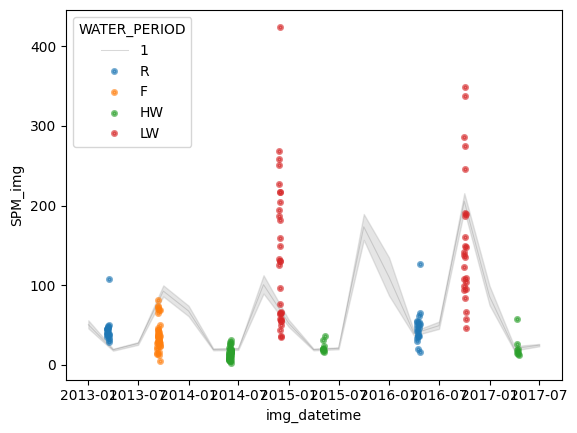

In [ ]:
import seaborn as sns
sns.lineplot(data=class_pred, x ='img_datetime',y= 'SPM_img',  alpha=.3,color='gray',size=1)
sns.pointplot(data=obs_points, x ='datetime',y= 'SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=True)